<a href="https://colab.research.google.com/github/neeraj-iitm/Kalman-Filter-for-Manoeuvring-Targets/blob/main/KF_Simulation_Both_Components_of_Spiral_Trajetory.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  $ \Huge \ \ -- \ Simulation \ --$


## Import
Lets Start by importing necessary libraries,

In [ ]:
#---- Local Imports
from utils.PQ_matrices import P_cov, Q_cov
from utils.transfer_function import *
import utils.syntheticmeasurements as sms
from utils.mkf_internal import plot_track
from book_plots import reset_figsize

#---- Library Imports
import pandas as pd
import numpy as np
from matplotlib.pyplot import text
# from numpy import exp
from numpy.random import randn
from scipy.linalg import inv


#---- Plot imports
import matplotlib.pyplot as plt


## Intiate Variables and Compute Matrices
Lets declare our variables and find out the required Matrices. The values are taken directly from research paper.

$\sigma _m ^2 = \frac{A_{max}^2}{3}\times(1+4P_{max} - P_o)$

$\Phi(T, \alpha)=\left[\begin{array}{ccc}
1 & T & \frac{1}{\alpha^{2}}\left[-1+\alpha T+e^{-\alpha T}\right] \\
0 & 1 & \frac{1}{\alpha}\left[1-e^{-\alpha T}\right] \\
0 & 0 & e^{-a T}
\end{array}\right]\quad \quad \quad \quad$


$Q(k)=E\left[u(k) u^{T}(k)\right]=2 \alpha \sigma_{m}^{2}\left[\begin{array}{ccc}
q 11 & q 12 & q 13 \\
q 12 & q 22 & q 23 \\
q 13 & q 23 & 433
\end{array}\right]$

In [ ]:
Amax =  4*32
Pmax = 0.1
P_o = 0.5

T = 1
α = 0.1

In [ ]:
σ_m = (((Amax**2)/3)*(1+4*Pmax - P_o))**0.5
σ_r = 600

P = P_cov(σ_r,σ_m,α,T)
Q = Q_cov(σ_m, α,T)
R = np.array([[σ_r**2]])

F = transfer_function(α,T)
H = np.array([[1., 0., 0.]])
x = np.array([[0, 0, 0 ]]).T

## Get Measurements

In [ ]:
θ = np.arange(-3.14*10, 3.14*10, 0.1)
r = [10 for i in range(len(θ))]

xc = [r[i]*np.cos(j) for (i,j) in enumerate(θ)]
yc = [r[i]*np.sin(j) for (i,j) in enumerate(θ)]

merged = []
for i in range(len(xc)):
    merged.append([[xc[i]],[yc[i]]])
    

## $ \textbf{Apply Kalman  Filter}$


The objective of the paper was to find out the $\text{Transition matrix} \ \Phi$ and the covariance matrices for the given problem. This snippet executes the Kalman Filter using the respective $P$ and $Q$ covariance matrices from paper.

In [ ]:
P = np.array([
    [P[0][0], P[0][1], P[0][2],  0,      0,       0    ],
    [P[1][0], P[1][1], P[1][2],  0,      0,       0    ],
    [P[2][0], P[2][1], P[2][2],  0,      0,       0    ],
    [    0,     0,      0,    P[0][0], P[0][1], P[0][2]],
    [    0,     0,      0,    P[1][0], P[1][1], P[1][2]],
    [    0,     0,      0,    P[2][0], P[2][1], P[2][2]], 
    
    ])



In [ ]:
Q = np.array([
    [Q[0][0], Q[0][1], Q[0][2],  0,       0,       0   ],
    [Q[1][0], Q[1][1], Q[1][2],  0,       0,       0   ],
    [Q[2][0], Q[2][1], Q[2][2],  0,       0,       0   ],
    [    0,     0,      0,    Q[0][0], Q[0][1], Q[0][2]],
    [    0,     0,      0,    Q[1][0], Q[1][1], Q[1][2]],
    [    0,     0,      0,    Q[2][0], Q[2][1], Q[2][2]], 
    
    ])


In [ ]:
F = np.array([
    [F[0][0], F[0][1], F[0][2],  0,       0,       0   ],
    [F[1][0], F[1][1], F[1][2],  0,       0,       0   ],
    [F[2][0], F[2][1], F[2][2],  0,       0,       0   ],
    [    0,     0,      0,    F[0][0], F[0][1], F[0][2]],
    [    0,     0,      0,    F[1][0], F[1][1], F[1][2]],
    [    0,     0,      0,    F[2][0], F[2][1], F[2][2]], 
    
    ])


In [ ]:
H =(np.array([[1,0,0,0,0,0],
              [0,0,0,1,0,0]]))

In [ ]:
R = np.array([
    [ σ_r**2,    0  ],
    [   0,    σ_r**2]
])


In [ ]:
x = np.array([[0, 0, 0, 0, 0, 0]]).T

In [ ]:
xs =[]
cov= []

for z in merged:
    
    # predict
    x = F @ x
    P = F @ P @ F.T + Q
    
    #update
    S = H @ P @ H.T + R
    K = P @ H.T @ inv(S)
    y = z - H @ x
    x += K @ y
    P = P - K @ H @ P
    
    xs.append(x)
    cov.append(P)

xs, cov = np.array(xs), np.array(cov)

In [ ]:
x_meas = []
y_meas = []
for i in merged:
    x_meas.append(i[0])
    y_meas.append(i[1])

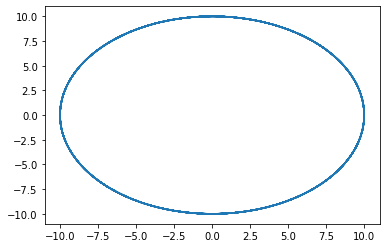

In [ ]:
plt.plot(x_meas, y_meas)

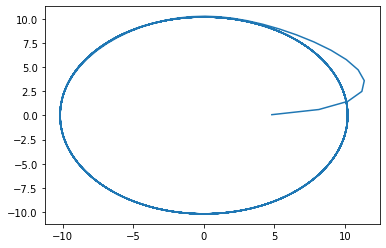

In [ ]:
x_fil = []
y_fil = []
for kk in xs:
    x_fil.append(kk[0])
    y_fil.append(kk[3])
plt.plot(x_fil, y_fil)

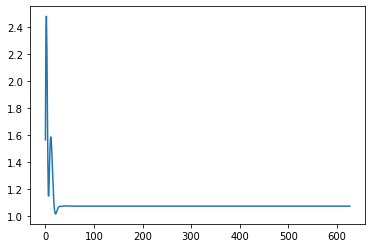

In [ ]:
v = []
vx_fil = []
vy_fil = []
for kk in xs:
    vx_fil.append(kk[1])
    vy_fil.append(kk[4])    
    v.append((kk[1]**2 + kk[4]**2)**0.5)
plt.plot(v)

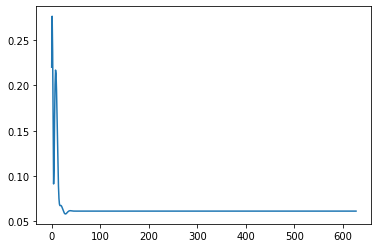

In [ ]:
a=[]
ax_fil = []
ay_fil = []
for kk in xs:
    ax_fil.append(kk[2])
    ay_fil.append(kk[5])
    a.append((kk[2][0]**2 + kk[5][0]**2)**0.5)
plt.plot(a)

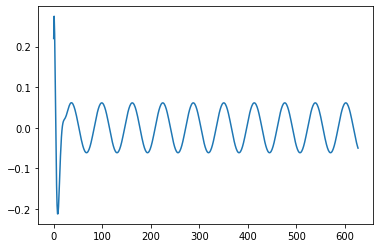

In [ ]:
plt.plot(ax_fil)

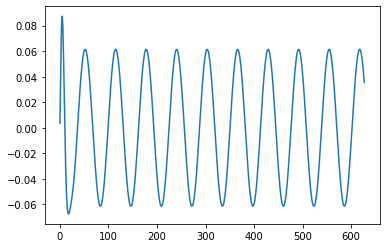

In [ ]:
plt.plot(ay_fil)

-----